## Libraries

In [2]:
import os
import glob
import numpy as np
import librosa
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import scipy.signal
import matplotlib.pyplot as plt

In [26]:
def resample_features(feat_array, target_count):
    if feat_array.size == 0 or feat_array.ndim != 2:
        # Handle empty or invalid arrays by returning zeros
        return np.zeros((target_count, feat_array.shape[1] if feat_array.ndim == 2 else 2))
    
    num_segments, feat_dim = feat_array.shape
    
    if num_segments == target_count:
        return feat_array  # No change needed
    
    elif num_segments < target_count:
        # Too few segments - upsample by interpolation
        # Create indices for interpolation
        orig_indices = np.arange(num_segments)
        new_indices = np.linspace(0, num_segments - 1, target_count)
        
        # Create array to store interpolated features
        resampled = np.zeros((target_count, feat_dim))
        
        # Interpolate each feature dimension
        for i in range(feat_dim):
            resampled[:, i] = np.interp(new_indices, orig_indices, feat_array[:, i])
        
        return resampled
    
    else:  
        # Too many segments - downsample by averaging chunks
        indices = np.linspace(0, num_segments, num=target_count+1, dtype=int)
        return np.array([np.mean(feat_array[indices[i]:indices[i+1]], axis=0) 
                         for i in range(target_count)])


In [9]:

# Path to dataset
dataset_folder = "Speech Dataset"
file_list = glob.glob(os.path.join(dataset_folder, "*.wav"))

# Dictionary to store extracted features
features_dict = {}


## MFCC Features

In [5]:

def extract_mfcc_detailed(audio_path, sr=16000, n_mfcc=13, frame_length=0.025, 
                        frame_step=0.01, preemphasis=0.97, n_fft=512, 
                        n_mels=40, fmin=0, fmax=None, ceplifter=22):
    """
    Extract MFCC features with explicit control over each step in the process.
    
    Parameters:
    -----------
    audio_path : str
        Path to the audio file.
    sr : int
        Sampling rate for loading audio.
    n_mfcc : int
        Number of MFCC coefficients to extract.
    frame_length : float
        Frame length in seconds.
    frame_step : float
        Frame step in seconds.
    preemphasis : float
        Pre-emphasis filter coefficient.
    n_fft : int
        FFT size.
    n_mels : int
        Number of Mel filter banks.
    fmin : int
        Lowest frequency (in Hz).
    fmax : int or None
        Highest frequency (in Hz). If None, sr/2 is used.
    ceplifter : int
        Apply a lifter to final cepstral coefficients.
        
    Returns:
    --------
    mfcc_features : ndarray
        Concatenated mean and std of MFCC coefficients.
    """
    # Load audio
    audio, sr = librosa.load(audio_path, sr=sr)
    
    # STEP 1: Pre-emphasis
    # Apply pre-emphasis filter to boost high frequencies
    emphasized_audio = np.append(audio[0], audio[1:] - preemphasis * audio[:-1])
    
    # STEP 2: Framing
    # Convert frame length and step from seconds to samples
    frame_length_samples = int(sr * frame_length)
    frame_step_samples = int(sr * frame_step)
    
    # Calculate total frames
    num_frames = 1 + int(np.ceil((len(emphasized_audio) - frame_length_samples) / frame_step_samples))
    
    # Zero padding to ensure we have enough samples for all frames
    pad_length = num_frames * frame_step_samples + frame_length_samples - len(emphasized_audio)
    padded_audio = np.append(emphasized_audio, np.zeros(pad_length))
    
    # Extract frames
    frames = np.zeros((num_frames, frame_length_samples))
    for i in range(num_frames):
        start = i * frame_step_samples
        frames[i] = padded_audio[start:start + frame_length_samples]
    
    # Apply window function (Hamming window)
    frames = frames * np.hamming(frame_length_samples)
    
    # STEP 3: FFT and Power Spectrum
    # Compute FFT
    mag_frames = np.abs(np.fft.rfft(frames, n_fft))
    
    # Compute power spectrum
    pow_frames = (mag_frames ** 2) / n_fft
    
    # STEP 4: Mel Filterbank
    # Get Mel filterbank
    mel_basis = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels, fmin=fmin, fmax=fmax)
    
    # Apply Mel filterbank
    mel_spec = np.dot(pow_frames, mel_basis.T)
    
    # Log-compress (avoid log of zero)
    log_mel_spec = np.log(mel_spec + 1e-10)
    
    # STEP 5: DCT (Discrete Cosine Transform)
    # Apply DCT to get MFCCs
    mfcc = scipy.fft.dct(log_mel_spec, type=2, axis=1, norm='ortho')[:, :n_mfcc]
    
    # Apply liftering to emphasize lower order coefficients (optional)
    if ceplifter > 0:
        ncoeffs = n_mfcc
        lift = 1 + (ceplifter / 2) * np.sin(np.pi * np.arange(ncoeffs) / ceplifter)
        mfcc *= lift
    
    # STEP 6: Statistical pooling (mean and std)
    mfcc_mean = np.mean(mfcc, axis=0)
    mfcc_std = np.std(mfcc, axis=0)
    mfcc_features = np.concatenate([mfcc_mean, mfcc_std])
    
    return mfcc_features, mfcc



In [10]:
def extract_and_save_mfccs(file_list, output_path=None):
    """
    Extract MFCC features for a list of audio files and save them to a DataFrame.
    
    Parameters:
    -----------
    file_list : list
        List of paths to audio files.
    output_path : str or None
        If provided, save the DataFrame to this path.
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing MFCC features for each file.
    """
    mfcc_dict = {}
    mfcc_data = {}  # Store full MFCCs for visualization
    
    print("Extracting detailed MFCC features...")
    for file_path in tqdm(file_list, desc="Processing MFCC", unit="file"):
        mfcc_feat, full_mfcc = extract_mfcc_detailed(file_path)
        mfcc_dict[file_path] = mfcc_feat
        mfcc_data[file_path] = full_mfcc
    
    # Create DataFrame
    df_mfcc = pd.DataFrame.from_dict(mfcc_dict, orient='index')
    
    # Add column names
    n_mfcc = len(mfcc_feat) // 2
    column_names = []
    for i in range(n_mfcc):
        column_names.append(f'mfcc_mean_{i+1}')
    for i in range(n_mfcc):
        column_names.append(f'mfcc_std_{i+1}')
    df_mfcc.columns = column_names
    
    # Save to file if output path provided
    if output_path:
        df_mfcc.to_csv(output_path, index=True)
        print(f"MFCC features saved to {output_path}")
    
    return df_mfcc, mfcc_data

def visualize_mfccs(mfcc_data, file_path, save_path=None):
    """
    Visualize MFCCs for a specific audio file.
    
    Parameters:
    -----------
    mfcc_data : dict
        Dictionary containing MFCCs for each file.
    file_path : str
        Path to the audio file to visualize.
    save_path : str or None
        If provided, save the visualization to this path.
    """
    mfcc = mfcc_data[file_path]
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time', sr=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'MFCC for {file_path}')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    plt.show()


Extracting detailed MFCC features...


Processing MFCC: 100%|██████████| 535/535 [00:12<00:00, 41.92file/s]


MFCC features saved to mfcc_features.csv


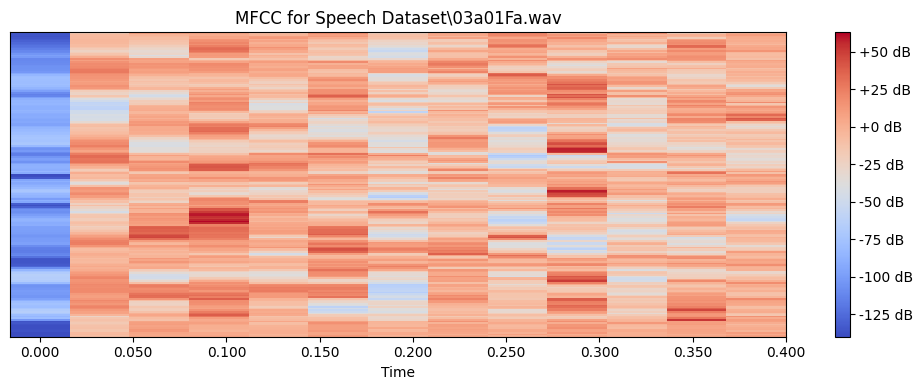

In [11]:

# Extract MFCCs
df_mfcc, mfcc_data = extract_and_save_mfccs(file_list, output_path="mfcc_features.csv")
    
# Visualize MFCCs for the first file
if file_list:
        visualize_mfccs(mfcc_data, file_list[0])

## 1. Utterence Level

In [12]:
def extract_prosody_utterance(audio, sr):
    """Extract pitch and energy statistics for the full utterance."""
    f0, voiced_flag, _ = librosa.pyin(audio, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    valid_f0 = f0[~np.isnan(f0)]
    pitch_mean = np.mean(valid_f0) if valid_f0.size > 0 else 0
    pitch_std = np.std(valid_f0) if valid_f0.size > 0 else 0
    rms = librosa.feature.rms(y=audio)[0]
    return np.array([pitch_mean, pitch_std, np.mean(rms), np.std(rms)])



In [13]:
prosody_utt_dict = {}

print("Extracting Prosody features (Utterance Level)...")
for file_path in tqdm(file_list, desc="Prosody-Utterance", unit="file"):
    audio, sr = librosa.load(file_path, sr=16000)
    feat = extract_prosody_utterance(audio, sr)
    prosody_utt_dict[file_path] = feat



Extracting Prosody features (Utterance Level)...


Prosody-Utterance: 100%|██████████| 535/535 [09:15<00:00,  1.04s/file]


In [14]:
df_utt = pd.DataFrame.from_dict(prosody_utt_dict, orient='index')
df_utt.insert(0, "file", [os.path.basename(f) for f in df_utt.index])
df_utt.columns = ['file', 'PitchMean', 'PitchStd', 'EnergyMean', 'EnergyStd']
df_utt.to_csv("prosody_utterance.csv", index=False)


## 2. Word Level

In [27]:

def segment_words(audio, sr, top_db=20, min_duration_samples=400):
    
    # Get non-silent intervals
    intervals = librosa.effects.split(audio, top_db=top_db)
    
    # Filter out very short segments
    valid_intervals = [interval for interval in intervals 
                      if (interval[1] - interval[0]) >= min_duration_samples]
    
    # Extract segments
    segments = [audio[start:end] for start, end in valid_intervals]
    
    return segments


def extract_word_level_features(audio, sr, fixed_word_count=7):
    # Segment into words
    word_segments = segment_words(audio, sr, top_db=20, min_duration_samples=int(0.05*sr))
    
    if not word_segments:
        # No words detected, return zeros
        return np.zeros(fixed_word_count * 4)  # 4 features per word
    
    # Extract features for each word segment
    word_features = []
    for segment in word_segments:
        # Skip if segment is too short
        if len(segment) < int(0.025*sr):
            continue
            
        # Extract pitch (f0)
        f0, voiced_flag, voiced_probs = librosa.pyin(
            segment, 
            fmin=librosa.note_to_hz('C2'), 
            fmax=librosa.note_to_hz('C7'),
            sr=sr
        )
        valid_f0 = f0[~np.isnan(f0)]
        pitch_mean = np.mean(valid_f0) if valid_f0.size > 0 else 0
        pitch_std = np.std(valid_f0) if valid_f0.size > 0 else 0
        
        # Energy (RMS)
        rms = librosa.feature.rms(y=segment)[0]
        energy_mean = np.mean(rms) if rms.size > 0 else 0
        energy_std = np.std(rms) if rms.size > 0 else 0
        
        # Combined features for this word
        word_features.append([pitch_mean, pitch_std, energy_mean, energy_std])
    
    # Convert to numpy array
    if word_features:
        word_features = np.array(word_features)
    else:
        # If no valid segments were found
        word_features = np.zeros((1, 4))
    
    # Resample to fixed number of words
    resampled_features = resample_features(word_features, fixed_word_count)
    
    # Flatten to 1D array
    return resampled_features.flatten()

def extract_and_save_word_features(file_list, output_path="word_level_features.csv", fixed_word_count=7):
    feature_dict = {}
    
    print(f"Extracting word-level features (standardized to {fixed_word_count} words)...")
    for file_path in tqdm(file_list, desc="Word-Level Features", unit="file"):
        try:
            audio, sr = librosa.load(file_path, sr=16000)
            features = extract_word_level_features(audio, sr, fixed_word_count=fixed_word_count)
            feature_dict[file_path] = features
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            # Use zeros for failed files
            feature_dict[file_path] = np.zeros(fixed_word_count * 4)
    
    # Create DataFrame
    df = pd.DataFrame.from_dict(feature_dict, orient='index')
    
    # Add filename column
    df.insert(0, "file", [os.path.basename(f) for f in df.index])
    
    # Name columns properly
    feature_names = []
    for i in range(fixed_word_count):
        feature_names.extend([
            f"Word_{i+1}_Pitch_Mean",
            f"Word_{i+1}_Pitch_Std",
            f"Word_{i+1}_Energy_Mean",
            f"Word_{i+1}_Energy_Std"
        ])
    
    df.columns = ['file'] + feature_names
    
    # Save to CSV
    df.to_csv(output_path, index=False)
    print(f"Word-level features saved to {output_path}")
    
    return df

def visualize_word_segmentation(audio_path, output_path=None):
    # Load audio
    audio, sr = librosa.load(audio_path, sr=16000)
    
    # Get word segments
    intervals = librosa.effects.split(audio, top_db=20)
    
    # Prepare the plot
    plt.figure(figsize=(12, 6))
    
    # Plot waveform
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(audio))/sr, audio)
    plt.title("Audio Waveform with Word Segments")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    
    # Highlight word segments
    for start, end in intervals:
        plt.axvspan(start/sr, end/sr, color='red', alpha=0.3)
    
    # Plot spectrogram
    plt.subplot(2, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Spectrogram with Word Segments")
    
    # Highlight word segments on spectrogram
    for start, end in intervals:
        plt.axvspan(start/sr, end/sr, color='red', alpha=0.3)
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path)
    
    plt.show()



In [ ]:
# Extract word-level features
df_word = extract_and_save_word_features(file_list, "word_level_features.csv", fixed_word_count=7)



Extracting word-level features (standardized to 7 words)...


Word-Level Features: 100%|██████████| 535/535 [09:00<00:00,  1.01s/file]

Word-level features saved to word_level_features.csv


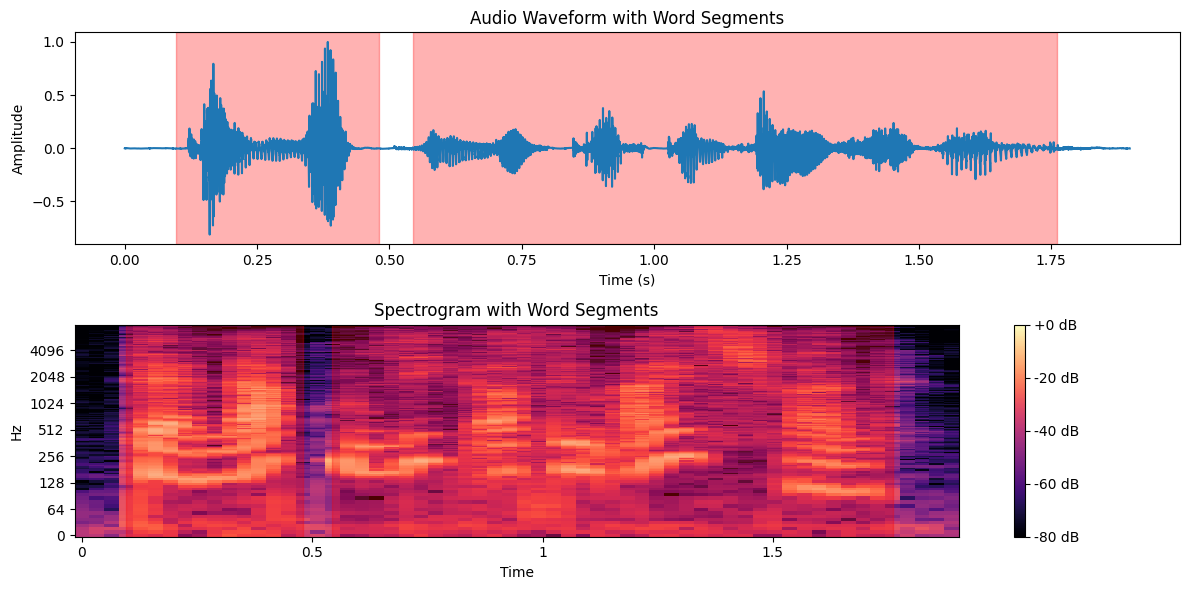

In [29]:
    
# Visualize word segmentation for the first file
if file_list:
        visualize_word_segmentation(file_list[0], "word_segmentation.png")

## 3. Syllable Level

In [30]:
def segment_syllables(audio, sr):
    """Segment audio into syllable-like chunks using onset detection."""
    onset_frames = librosa.onset.onset_detect(y=audio, sr=sr)
    onset_samples = np.append(librosa.frames_to_samples(onset_frames), len(audio))
    return [audio[onset_samples[i]:onset_samples[i+1]] for i in range(len(onset_samples)-1)]


In [31]:
def extract_prosody_syllable(audio, sr, fixed_syllables=15):
    """Extract mean pitch & energy for each syllable and resample."""
    segments = segment_syllables(audio, sr)
    feats = []
    for seg in segments:
        f0, _, _ = librosa.pyin(seg, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
        valid_f0 = f0[~np.isnan(f0)]
        pitch_mean = np.mean(valid_f0) if valid_f0.size > 0 else 0
        rms = librosa.feature.rms(y=seg)[0]
        energy_mean = np.mean(rms) if rms.size > 0 else 0
        feats.append([pitch_mean, energy_mean])
    return resample_features(np.vstack(feats) if feats else np.zeros((1, 2)), fixed_syllables).flatten()



In [32]:
prosody_syll_dict = {}

print("Extracting Prosody features (Syllable Level)...")
for file_path in tqdm(file_list, desc="Prosody-Syllable", unit="file"):
    audio, sr = librosa.load(file_path, sr=16000)
    feat = extract_prosody_syllable(audio, sr, fixed_syllables=15)
    prosody_syll_dict[file_path] = feat


Extracting Prosody features (Syllable Level)...


Prosody-Syllable: 100%|██████████| 535/535 [25:00<00:00,  2.80s/file]


In [33]:

df_syll = pd.DataFrame.from_dict(prosody_syll_dict, orient='index')
df_syll.insert(0, "file", [os.path.basename(f) for f in df_syll.index])
# Rename columns
df_syll.columns = ['file'] + [f"Syll_Pitch_{i+1}" for i in range(15)] + [f"Syll_Energy_{i+1}" for i in range(15)]
df_syll.to_csv("prosody_syllable.csv", index=False)
